# ChainerRL で atari のゲームを DQN で解かしてみる

このNotebookは初めてChainerRL で atari のゲームを DQN で解かしてみるサンプルです。

|凡例||
|--||
|❔|参考になるメモです。|


以下のコマンドを実行してChainerRLをインストールします。

In [0]:
!apt-get -qq -y update
# Install Chainer and CuPy!
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip -q install 'cupy-cuda80==4.0.0b4 ' 'chainer==4.0.0b4'
# Install ChainerRL and OpenAI Gym
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg cmake swig zlib1g-dev> /dev/null
!pip -q install chainerrl atari-py gym 'gym[atari]' 'gym[box2d]'  pyglet pyopengl pyvirtualdisplay

Extracting templates from packages: 100%


## Google ドライブにデータを保存する準備。

atari のゲームを DQNで学習させると、とても時間がかかります。そのため、Google drive に経過を保存できるように、マウントしておきましょう。([参考](https://funmatu.wordpress.com/2017/11/30/colaboratory%E3%81%A7%E7%B0%A1%E5%8D%98%E4%BE%BF%E5%88%A9%E3%81%AB%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AE%E3%82%84%E3%82%8A%E5%8F%96%E3%82%8A%E3%82%92%E3%81%99%E3%82%8B%E6%96%B9%E6%B3%95/))

❔Colaboratory は、12時間を超えて継続できません。また、90分アイドルが続くと、ランタイムは解放されます。その他の制限は、[こちら](https://qiita.com/tomo_makes/items/b3c60b10f7b25a0a5935)が詳しいです。

次のコードセルをを実行し、以下の手順で Google アカウントの認証を行います。

1. URLが表示されるのでそれをクリック
2. Google アカウントにログイン
3. 表示されるトークンをコピー
4. このノートに戻って、テキストボックスにそのトークンを貼り付け
5. 再度URLが表示されるのでそれをクリック
6. このノートに戻って、テキストボックスにそのトークンを貼り付け

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse > /dev/null

from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

## 環境の準備

まず、必要なモジュールをインポートする必要があります。 ChainerRLのモジュール名は `chainerrl`です。 ale というのは、[Arcade Learning Environment](https://github.com/mgbellemare/Arcade-Learning-Environment)で、Atari 2600　のゲームの環境です。

In [0]:
import chainer
from chainer import functions as F
from chainer import links as L
import chainerrl
from chainerrl.envs import ale
import numpy as np

では、環境を作ります。

Quickstartであった通り、ChainerRLは [OpenAI Gym](https://github.com/openai/gym) のサブセットが環境として使用可能です。 

ここでは、breakout を試してみましょう。breakoutは、ブロック崩しです。[こちら](https://gym.openai.com/envs/Breakout-ram-v0/)でゲームの様子を見ることができます。

`chainerrl.experiments.prepare_output_dir` ではログ出力のディレクトリを設定します。

`ale.ALE`で環境を作ります。学習用の環境と、バリデーション用の環境を作ります。

また、学習用の環境は、報酬を -1〜1の範囲にクリップするため、`chainerrl.misc.env_modifiers.make_reward_clipped`を呼び出します。

In [0]:
outdir = chainerrl.experiments.prepare_output_dir(None, "drive/dqn_out")

ROM = "breakout"
TRAIN_SEED = 0
TEST_SEED = 2 ** 16 - 1 - TRAIN_SEED

env = ale.ALE(ROM, use_sdl=False, seed=TRAIN_SEED)
chainerrl.misc.env_modifiers.make_reward_clipped(env, -1, 1)
eval_env = ale.ALE(ROM, use_sdl=False,
                       treat_life_lost_as_terminal=False,
                       seed=TEST_SEED)

n_actions = env.number_of_actions

次にQ関数、Optimizerを作ります。ここでは、[Nature版の論文](https://www.nature.com/articles/nature14236)に掲載されていたモデルを作ります。

`chainerrl.links.NatureDQNHead()`で末尾のFCレイヤー以外のモデルが作成されます。

Optimizer も、Nature版の論文と同じものを設定しています。



In [0]:
q_func = chainerrl.links.Sequence(
            chainerrl.links.NatureDQNHead(),
            L.Linear(512, n_actions),
            chainerrl.action_value.DiscreteActionValue)

# Use the same hyper parameters as the Nature paper's
optimizer = chainer.optimizers.RMSpropGraves(lr=2.5e-4, alpha=0.95, momentum=0.0, eps=1e-2)

optimizer.setup(q_func)

次に、Experience reply の為のバッファーを作成と、探索を行うための Explorer を作成します。

In [0]:
rbuf = chainerrl.replay_buffer.ReplayBuffer(10 ** 6)

explorer = chainerrl.explorers.LinearDecayEpsilonGreedy(
        1.0, 0.1,
        10 ** 6,
        lambda: np.random.randint(n_actions))

# In testing DQN, randomly select 5% of actions
eval_explorer = chainerrl.explorers.ConstantEpsilonGreedy(5e-2, lambda: np.random.randint(n_actions))

そして、Agent を作成します。

In [0]:
def dqn_phi(screens):
    assert len(screens) == 4
    assert screens[0].dtype == np.uint8
    raw_values = np.asarray(screens, dtype=np.float32)
    # [0,255] -> [0, 1]
    raw_values /= 255.0
    return raw_values

agent = chainerrl.agents.DQN(q_func, optimizer, rbuf, gpu=0, gamma=0.99,
                explorer=explorer, replay_start_size=5 * 10 ** 4,
                target_update_interval=10 ** 4,
                clip_delta=True,
                update_interval=4,
                batch_accumulator='sum', phi=dqn_phi)

## 学習

では、学習を開始してみましょう。これは、**10時間ほどかかります。**

その間、**Colaboratoryのウインドウを閉じないように、またPCがサスペンドにならないように注意してください。**

In [0]:
chainerrl.experiments.train_agent_with_evaluation(
    agent=agent, env=env, steps=10 ** 7,
    eval_n_runs=10, eval_interval=10 ** 5,
    outdir=outdir, eval_explorer=eval_explorer,
    eval_env=eval_env)

/usr/local/lib/python3.6/dist-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')
/usr/local/lib/python3.6/dist-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")
/usr/local/lib/python3.6/dist-packages/chainerrl/envs/ale.py:29: UserWarning: Since cv2 is not available PIL will be used instead to resize images. This might affect the resulting images.
  'Since cv2 is not available PIL will be used instead to resize images.'


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


## モデルの再ロード

学習が終わった後、暫く放置しているなどで、Runtimeが切れているかもしれないので、ここで再ロードをしておきます。

以下で、drive/dqn_out/ 以下の最新の model.npz を探します。

In [0]:
import pandas as pd
import glob
import os
model_files = glob.glob("drive/dqn_out/*/*/model.npz")
model_files.sort(key=os.path.getmtime)
last_model_dir = os.path.dirname(model_files[-1])
last_model_dir

'drive/dqn_out/20180401T130507.493354/10_finish'

そして、Agent を作成し、ロードします。

In [0]:
import chainer
from chainer import functions as F
from chainer import links as L
import chainerrl
from chainerrl.envs import ale
import numpy as np

ROM = "breakout"
TRAIN_SEED = 0
TEST_SEED = 2 ** 16 - 1 - TRAIN_SEED

env = ale.ALE(ROM, use_sdl=False, seed=TRAIN_SEED)
chainerrl.misc.env_modifiers.make_reward_clipped(env, -1, 1)
eval_env = ale.ALE(ROM, use_sdl=False,
                       treat_life_lost_as_terminal=False,
                       seed=TEST_SEED)

n_actions = env.number_of_actions
q_func = chainerrl.links.Sequence(
            chainerrl.links.NatureDQNHead(),
            L.Linear(512, n_actions),
            chainerrl.action_value.DiscreteActionValue)

# Use the same hyper parameters as the Nature paper's
optimizer = chainer.optimizers.RMSpropGraves(lr=2.5e-4, alpha=0.95, momentum=0.0, eps=1e-2)

optimizer.setup(q_func)

rbuf = chainerrl.replay_buffer.ReplayBuffer(10 ** 6)

explorer = chainerrl.explorers.LinearDecayEpsilonGreedy(
        1.0, 0.1,
        10 ** 6,
        lambda: np.random.randint(n_actions))

def dqn_phi(screens):
    assert len(screens) == 4
    assert screens[0].dtype == np.uint8
    raw_values = np.asarray(screens, dtype=np.float32)
    # [0,255] -> [0, 1]
    raw_values /= 255.0
    return raw_values

agent = chainerrl.agents.DQN(q_func, optimizer, rbuf, gpu=0, gamma=0.99,
                explorer=explorer, replay_start_size=5 * 10 ** 4,
                target_update_interval=10 ** 4,
                clip_delta=True,
                update_interval=4,
                batch_accumulator='sum', phi=dqn_phi)
agent.load(last_model_dir)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


NameError: ignored

## 学習結果の確認

"drive/dqn_out" 以下には、学習を開始した時刻でディレクトリが作成されています。

その中に、scores.txt が格納されているので、見てみましょう。mean、median等は、報酬の値の平均、中央値等示しています。 

In [0]:
import pandas as pd
import glob
import os
score_files = glob.glob("drive/dqn_out/*/scores.txt")
score_files.sort(key=os.path.getmtime)
score_file = score_files[-1]
df = pd.read_csv(score_file, delimiter='\t' )
df

,steps,episodes,elapsed,mean,median,stdev,max,min,average_q,average_loss
0,100019,2530,723.888525,2.7,0.0,4.347413,9.0,0.0,0.303997,0.150887
1,200069,5118,1658.790631,2.3,0.0,4.595892,11.0,0.0,0.338333,0.140443
2,300023,7698,2574.870919,3.6,2.0,3.864367,9.0,0.0,0.285880,0.077487
3,400034,10366,3497.920046,1.0,1.0,1.247219,4.0,0.0,0.310269,0.066922
4,500052,12999,4411.688253,3.4,3.0,1.173788,5.0,2.0,0.543558,0.084011
5,600004,15279,5314.304720,2.8,3.0,0.788811,4.0,1.0,0.667274,0.099451
6,700081,17123,6216.525888,4.7,5.0,1.159502,6.0,3.0,0.928593,0.161979
7,800057,18436,7138.914733,11.7,10.5,4.448470,19.0,7.0,0.863669,0.172142
8,900006,19416,8060.686812,18.9,19.0,5.839521,29.0,10.0,1.021046,0.209086
9,1000218,20234,8967.935466,19.3,17.0,8.781926,39.0,11.0,1.487955,0.275206


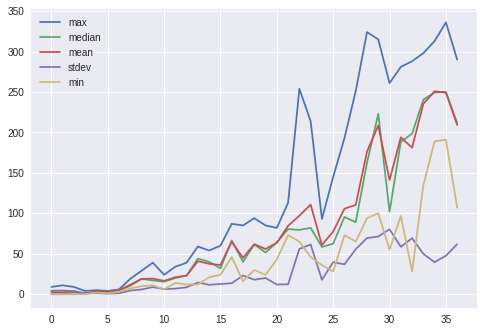

In [0]:
df[["max", "median", "mean", "stdev", "min"]].plot()

エピソードを重ねる毎に、報酬が増えていることが分かります。

## 実行結果の確認

chainerrl.env.ale には、`render()`が無かったので、ale の getScreenRGB() を使って、結果を確認します。

以下で、frames に画面を格納します。

In [0]:
frames = []
for i in range(10):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done:
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        frames.append(env.ale.getScreenRGB())
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()

以下で、アニメーションを作成します。

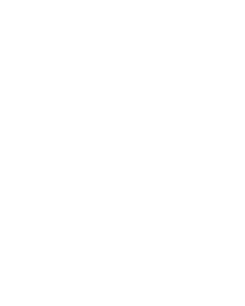

In [0]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

fig = plt.figure(figsize=(5, 5))
plt.axis('off')

images = []
for f in frames:
  image = plt.imshow(f)
  images.append([image])
ani = matplotlib.animation.ArtistAnimation(fig, images, interval=30, repeat_delay=1)

HTML(ani.to_jshtml())

まだ学習時間が不十分なようですが、ある程度、プレイできるようになっているのが確認できるかと思います。